In [1]:
##### 1
import gc
import re

import cv2
import math
import numpy as np
import scipy as sp
import pandas as pd
import pickle

import tensorflow as tf
from IPython.display import SVG
#import efficientnet.tfkeras as efn
from tensorflow.keras.utils import plot_model
import tensorflow.keras.layers as L
#from tensorflow.keras.utils import model_to_dot
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import ResNet50V2

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cmx


tqdm.pandas()
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

np.random.seed(0)
tf.random.set_seed(0)

import warnings
warnings.filterwarnings("ignore")

import os

2021-10-21 11:41:18.912986: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-21 11:41:18.913095: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
### paths declaration

EPOCHS = 20
SAMPLE_LEN = 100
train_impath = '../input/plant-pathology-2021-fgvc8/train_images'
test_impath = '../input/plant-pathology-2021-fgvc8/test_images'
train_csv = '../input/plant-pathology-2021-fgvc8/train.csv'
IMAGE_PATH = "../input/plant-pathology-2020-fgvc7/images/"
TEST_PATH = "../input/plant-pathology-2020-fgvc7/test.csv"
TRAIN_PATH = "../input/plant-pathology-2020-fgvc7/train.csv"

test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)

In [3]:
### processing csv

df_train = pd.read_csv(train_csv)
df_train.head()


image                           labels
0  800113bb65efe69e.jpg                          healthy
1  8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex
2  80070f7fb5e2ccaa.jpg                             scab
3  80077517781fb94f.jpg                             scab
4  800cbf0ff87721f8.jpg                          complex

In [4]:
### counting values of different labels

df_train['labels'].value_counts()

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

<AxesSubplot:xlabel='labels', ylabel='Count'>

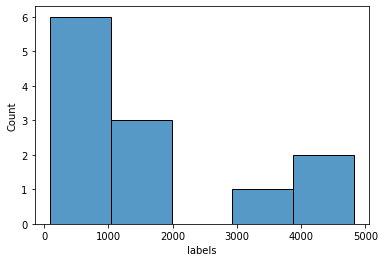

In [5]:
### projecting histogram plot against values

sns.histplot(df_train['labels'].value_counts(sort=True))

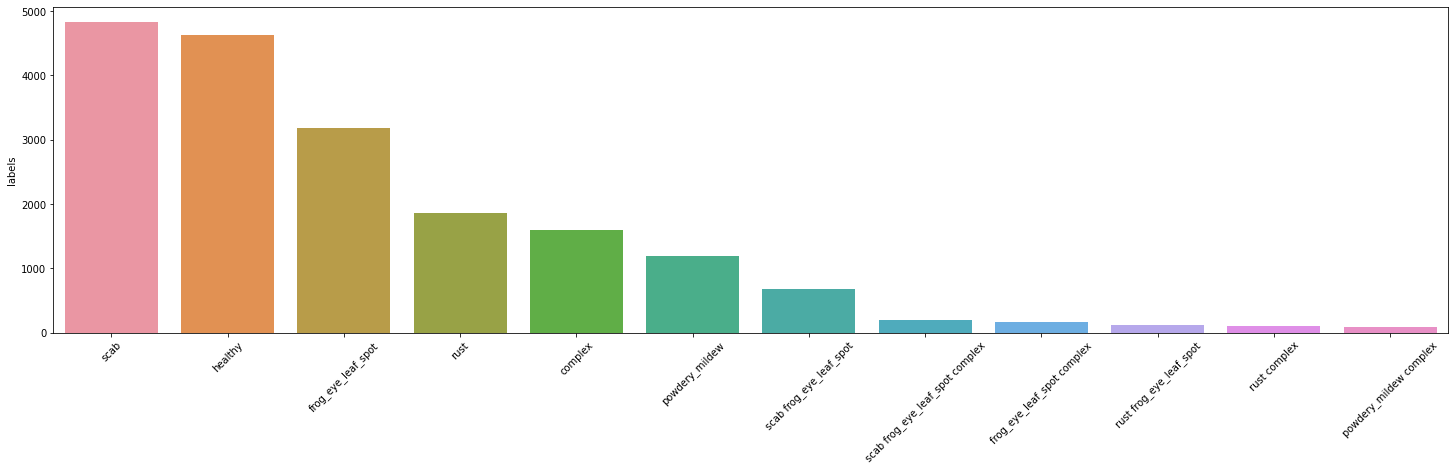

In [6]:
### projecting histgram plot for individual labels

plt.figure(figsize =(25, 6))
labels = sns.barplot(df_train['labels'].value_counts().index, df_train['labels'].value_counts())
for item in labels.get_xticklabels():
    item.set_rotation(45)

In [7]:
df_train['labels'] = df_train['labels'].apply(lambda string: string.split(' '))
df_train

image                               labels
0      800113bb65efe69e.jpg                            [healthy]
1      8002cb321f8bfcdf.jpg  [scab, frog_eye_leaf_spot, complex]
2      80070f7fb5e2ccaa.jpg                               [scab]
3      80077517781fb94f.jpg                               [scab]
4      800cbf0ff87721f8.jpg                            [complex]
...                     ...                                  ...
18627  fffb900a92289a33.jpg                            [healthy]
18628  fffc488fa4c0e80c.jpg                               [scab]
18629  fffc94e092a59086.jpg                               [rust]
18630  fffe105cf6808292.jpg           [scab, frog_eye_leaf_spot]
18631  fffe472a0001bd25.jpg                            [healthy]

[18632 rows x 2 columns]

In [8]:
### pie chart for the labels

source = df_train['labels'].value_counts()
fig = go.Figure(data=[go.Pie(labels=source.index, values=source.values)])
fig.update_layout(title='Label Distribution')
fig.show()

In [9]:
##### plant pathology

def visualize_batch(path,image_ids, labels):
    plt.figure(figsize=(16, 12))
    
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind + 1)
        image = cv2.imread(os.path.join(path, image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        plt.axis("off")
    plt.show()

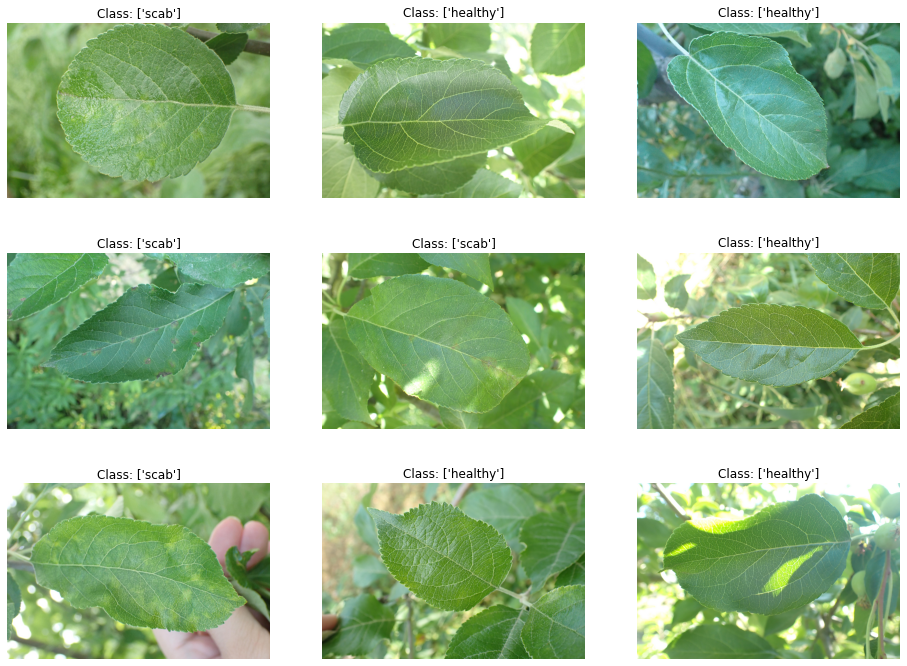

In [10]:
tmp_df = df_train.sample(9)
image_ids = tmp_df["image"].values
labels = tmp_df["labels"].values
visualize_batch(train_impath,image_ids,labels)

In [11]:
### converting BGR value to RGB Format

SAMPLE_LENGTH = 100

def load_image(image_id):
    file_path = image_id
    img = cv2.imread(train_impath+'/'+file_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


train_images = df_train['image'][:SAMPLE_LENGTH].apply(load_image)

In [12]:
### getting red, green and blue values from the sample images

red_values = [np.mean(train_images[idx][:, :, 0]) for idx in range(len(train_images))]
green_values = [np.mean(train_images[idx][:, :, 1]) for idx in range(len(train_images))]
blue_values = [np.mean(train_images[idx][:, :, 2]) for idx in range(len(train_images))]
values = [np.mean(train_images[idx]) for idx in range(len(train_images))]

In [13]:
### projection of red chanel values

fig = ff.create_distplot([red_values], group_labels=["R"], colors=["red"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of red channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig

In [14]:
### projection of green chanel values

fig = ff.create_distplot([green_values], group_labels=["G"], colors=["green"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of green channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig

In [15]:
### projection of blue chanel values

fig = ff.create_distplot([blue_values], group_labels=["B"], colors=["blue"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of blue channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig

In [16]:
### projection of RGB boxplot

fig = go.Figure()

for idx, values in enumerate([red_values, green_values, blue_values]):
    if idx == 0:
        color = "Red"
    if idx == 1:
        color = "Green"
    if idx == 2:
        color = "Blue"
    fig.add_trace(go.Box(x=[color]*len(values), y=values, name=color, marker=dict(color=color.lower())))
    
fig.update_layout(yaxis_title="Mean value", xaxis_title="Color channel",
                  title="Mean value vs. Color channel", template="plotly_white")

In [17]:
### combined projection
fig = ff.create_distplot([red_values, green_values, blue_values],
                         group_labels=["R", "G", "B"],
                         colors=["red", "green", "blue"])
fig.update_layout(title_text="Distribution of red channel values", template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig.data[2].marker.line.color = 'rgb(0, 0, 0)'
fig.data[2].marker.line.width = 0.5
fig

In [18]:
def edge_and_cut(img):
    emb_img = img.copy()
    edges = cv2.Canny(img, 100, 200)
    edge_coors = []
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i][j] != 0:
                edge_coors.append((i, j))
    
    row_min = edge_coors[np.argsort([coor[0] for coor in edge_coors])[0]][0]
    row_max = edge_coors[np.argsort([coor[0] for coor in edge_coors])[-1]][0]
    col_min = edge_coors[np.argsort([coor[1] for coor in edge_coors])[0]][1]
    col_max = edge_coors[np.argsort([coor[1] for coor in edge_coors])[-1]][1]
    new_img = img[row_min:row_max, col_min:col_max]
    
    emb_img[row_min-10:row_min+10, col_min:col_max] = [255, 0, 0]
    emb_img[row_max-10:row_max+10, col_min:col_max] = [255, 0, 0]
    emb_img[row_min:row_max, col_min-10:col_min+10] = [255, 0, 0]
    emb_img[row_min:row_max, col_max-10:col_max+10] = [255, 0, 0]
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=24)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=24)
    plt.show()

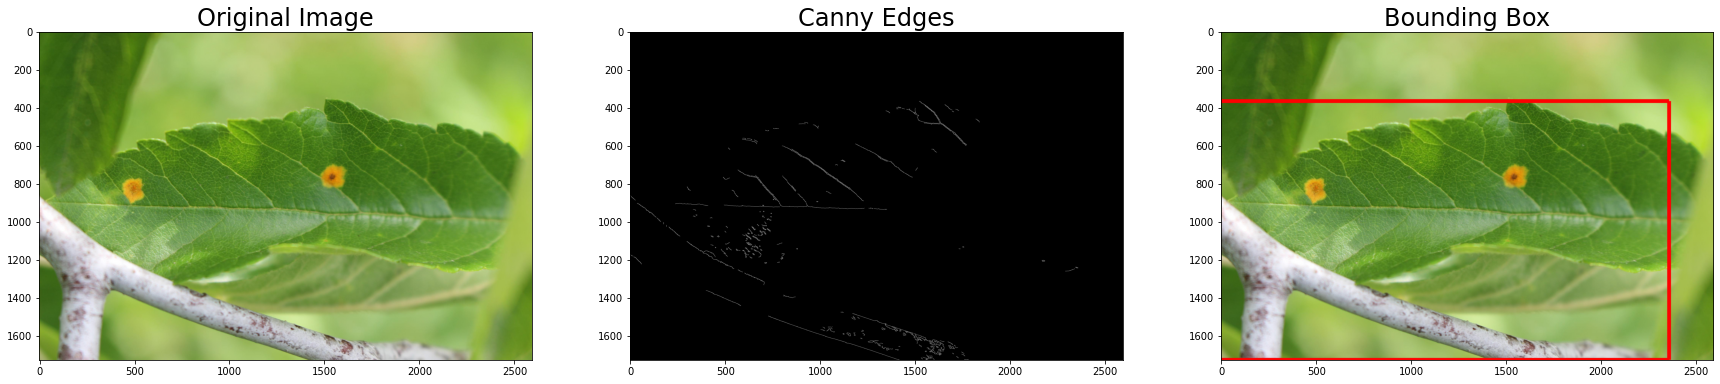

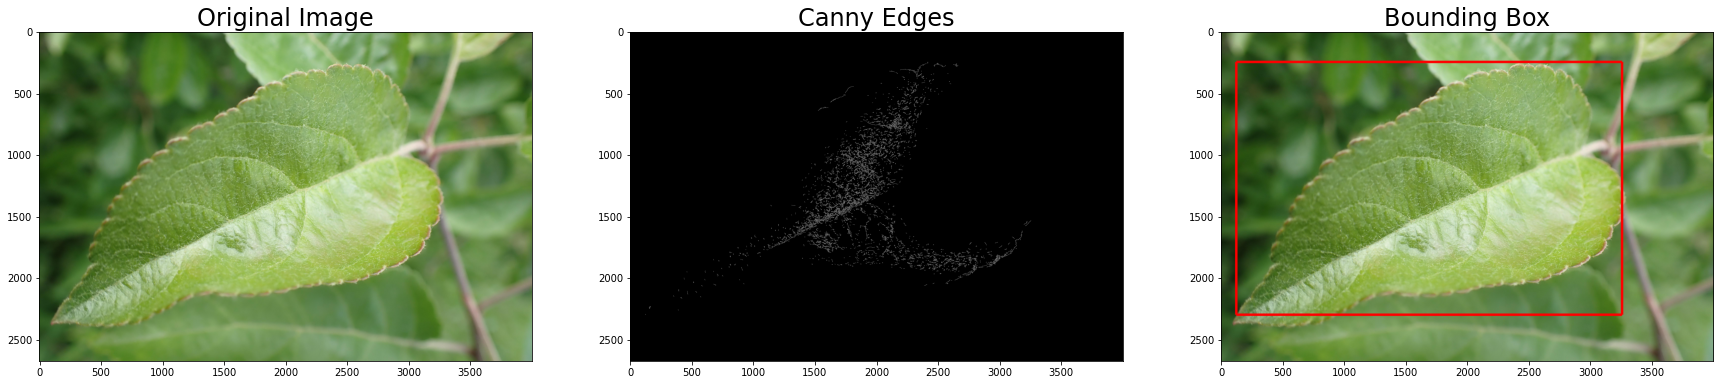

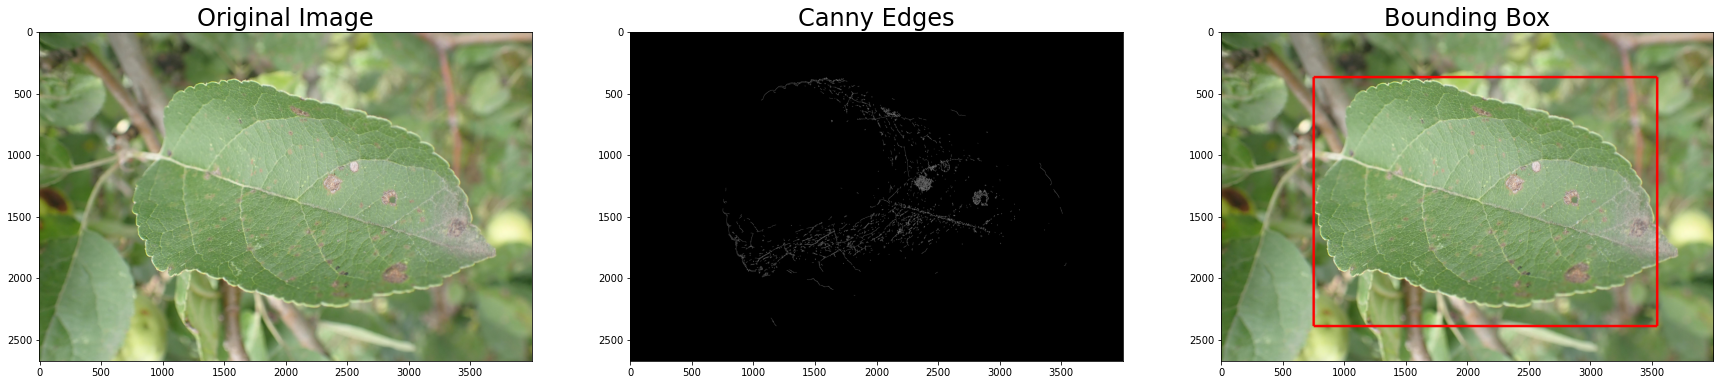

In [19]:
edge_and_cut(train_images[6])
edge_and_cut(train_images[7])
edge_and_cut(train_images[8])

### TRAINING DATASET

In [20]:
AUTO = tf.data.experimental.AUTOTUNE
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

BATCH_SIZE = 16 * strategy.num_replicas_in_sync
GCS_DS_PATH = KaggleDatasets().get_gcs_path('plant-pathology-2020-fgvc7')

2021-10-21 11:46:35.215125: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-21 11:46:35.218339: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-21 11:46:35.218373: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-21 11:46:35.218446: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (4da320762414): /proc/driver/nvidia/version does not exist
2021-10-21 11:46:35.222912: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [21]:
def format_path(st):
    return GCS_DS_PATH + '/images/' + st + '.jpg'

test_paths = test_data.image_id.apply(format_path).values
train_paths = train_data.image_id.apply(format_path).values

train_labels = np.float32(train_data.loc[:, 'healthy':'scab'].values)
train_paths, valid_paths, train_labels, valid_labels =\
train_test_split(train_paths, train_labels, test_size=0.15, random_state=2020)

In [22]:
def decode_image(filename, label=None, image_size=(512, 512)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [23]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

In [24]:
def build_lrfn(lr_start=0.00001, lr_max=0.00005, 
               lr_min=0.00001, lr_rampup_epochs=5, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

In [25]:
lrfn = build_lrfn()
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

In [26]:
### desneNet121
with strategy.scope():
    model = tf.keras.Sequential([DenseNet121(input_shape=(512, 512, 3),
                                             weights='imagenet',
                                             include_top=False),
                                 L.GlobalAveragePooling2D(),
                                 L.Dense(train_labels.shape[1],
                                         activation='softmax')])
        
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    model.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 16, 16, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 6,957,956
Non-trainable params: 83,648
_________________________________________________________________


In [27]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    callbacks=[lr_schedule],
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset)

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
12/12 [==============================] - 177s 6s/step - loss: 1.2768 - categorical_accuracy: 0.3558 - val_loss: 1.2931 - val_categorical_accuracy: 0.4051
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
12/12 [==============================] - 14s 1s/step - loss: 0.8558 - categorical_accuracy: 0.7026 - val_loss: 1.0241 - val_categorical_accuracy: 0.5985
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
12/12 [==============================] - 35s 3s/step - loss: 0.4008 - categorical_accuracy: 0.8856 - val_loss: 1.1470 - val_categorical_accuracy: 0.5073
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
12/12 [==============================] - 36s 3s/step - loss: 0.2297 - categorical_accuracy: 0.9294 - val_loss: 0.6414 - val_categorical_accuracy: 0.7810
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing lea

In [32]:
model.save("densenet_model.h5")

In [33]:
### ResNetv50
with strategy.scope():
    model_res = tf.keras.Sequential([ResNet50V2(input_shape=(512, 512, 3),
                                             weights='imagenet',
                                             include_top=False),
                                 L.GlobalAveragePooling2D(),
                                 L.Dense(train_labels.shape[1],
                                         activation='softmax')])
        
    model_res.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    model_res.summary()

94674944/94668760 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 16, 16, 2048)      23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 8196      
Total params: 23,572,996
Trainable params: 23,527,556
Non-trainable params: 45,440
_________________________________________________________________


In [34]:
history_res = model_res.fit(train_dataset,
                    epochs=EPOCHS,
                    callbacks=[lr_schedule],
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset)

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
12/12 [==============================] - 104s 4s/step - loss: 1.5669 - categorical_accuracy: 0.2193 - val_loss: 1.2284 - val_categorical_accuracy: 0.4051
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
12/12 [==============================] - 19s 2s/step - loss: 0.9731 - categorical_accuracy: 0.6377 - val_loss: 1.1290 - val_categorical_accuracy: 0.5657
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
12/12 [==============================] - 41s 4s/step - loss: 0.4423 - categorical_accuracy: 0.8590 - val_loss: 2.7658 - val_categorical_accuracy: 0.5693
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
12/12 [==============================] - 35s 3s/step - loss: 0.2307 - categorical_accuracy: 0.9290 - val_loss: 2.0765 - val_categorical_accuracy: 0.6752
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing lea

In [35]:
model_res.save("resnet_model.h5")

In [36]:
def display_training_curves(training, validation, yaxis):
    if yaxis == "loss":
        ylabel = "Loss"
        title = "Loss vs. Epochs"
    else:
        ylabel = "Accuracy"
        title = "Accuracy vs. Epochs"
        
    fig = go.Figure()
        
    fig.add_trace(
        go.Scatter(x=np.arange(1, EPOCHS+1), mode='lines+markers', y=training, marker=dict(color="dodgerblue"),
               name="Train"))
    
    fig.add_trace(
        go.Scatter(x=np.arange(1, EPOCHS+1), mode='lines+markers', y=validation, marker=dict(color="darkorange"),
               name="Val"))
    
    fig.update_layout(title_text=title, yaxis_title=ylabel, xaxis_title="Epochs", template="plotly_white")
    fig.show()

In [37]:
### DenseNet
display_training_curves(
    history.history['categorical_accuracy'], 
    history.history['val_categorical_accuracy'], 
    'accuracy')

In [38]:
### ResNet
display_training_curves(
    history_res.history['categorical_accuracy'], 
    history_res.history['val_categorical_accuracy'], 
    'accuracy')

In [39]:
def process(img):
    return cv2.resize(img/255.0, (512, 512)).reshape(-1, 512, 512, 3)
def predict(img):
    return model.layers[2](model.layers[1](model.layers[0](process(img)))).numpy()[0]
    

fig = make_subplots(rows=4, cols=2)
preds = predict(train_images[2])

colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Scab"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Multiple diseases"

colors[pred] = px.colors.qualitative.Plotly[1]
colors["Healthy"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[2], (205, 136))), row=1, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=1, col=2)
fig.update_layout(height=1200, width=800, title_text="DenseNet Predictions", showlegend=False)

preds = predict(train_images[0])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Multiple diseases"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[0], (205, 136))), row=2, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=2, col=2)

preds = predict(train_images[3])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Rust"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[3], (205, 136))), row=3, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=3, col=2)

preds = predict(train_images[1])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Scab"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[1], (205, 136))), row=4, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=4, col=2)

fig.update_layout(template="plotly_white")

In [45]:
def process(img):
    return cv2.resize(img/255.0, (512, 512)).reshape(-1, 512, 512, 3)
def predict(img):
    return model_res.layers[2](model_res.layers[1](model_res.layers[0](process(img)))).numpy()[0]

fig = make_subplots(rows=4, cols=2)
preds = predict(train_images[2])

colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Scab"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Multiple diseases"

colors[pred] = px.colors.qualitative.Plotly[1]
colors["Healthy"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[2], (205, 136))), row=1, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=1, col=2)
fig.update_layout(height=1200, width=800, title_text="ResNet Predictions", showlegend=False)

preds = predict(train_images[0])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Multiple diseases"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[0], (205, 136))), row=2, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=2, col=2)

preds = predict(train_images[3])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Rust"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[3], (205, 136))), row=3, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=3, col=2)

preds = predict(train_images[1])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Scab"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[1], (205, 136))), row=4, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=4, col=2)

fig.update_layout(template="plotly_white")